Vamos a implementar desde 0 con `tensorflow 2.0` un modelo tipo `pix2pix` para darle una imágen de baja calidad y que el modelo sea capaz de mejorar la calidad de la misma. (En concreto, de una flor con bajo detalle/boceto a una flor.)

In [1]:
# Activamos la versión 2 de tensorflow para tener el eager mode
# Mas info: https://www.tensorflow.org/guide/eager
%tensorflow_version 2.x

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Ruta raiz
PATH = "/content/drive/MyDrive/Flowers"

# Ruta de datos de entrada y salida
INPATH = PATH + "/InputFlowers"
OUTPATH = PATH + "/OutputFlowers"
# Ruta de checkpoints
CKPATH = PATH + "/Checkpoints"

# Primero pillamos todas las fotos de INPATH en una lista
# Ejecutamos un comando de bash y con -1 lo devuelve en una lista en vez de columnas
imgurls = !ls -1 "{INPATH}"

In [2]:
# Vamos a desordenar las imágenes para entrenar a la red neuronal correctamente
n = 500 # trabajremos con 500 imágenes
train_n = round(n * 0.80) # 80% para el dataset de entrenamiento (y 20% para test :/)

# Randomizar
randurls = np.copy(imgurls)

 # Esto es para el tutorial, así todos tenemos las fotos igual de desordenadas
 # osea, tras desordenar todos tenemos el mismo orden de fotos
np.random.seed(23)

np.random.shuffle(randurls)

# Peticion de train/test
tr_urls = randurls[:train_n] # Pillamos el primer 80%
ts_urls = randurls[train_n:n] # Y luego el resto (el 20%)

print(len(imgurls), len(tr_urls), len(ts_urls))

8189 400 100


In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Reescalar las imágenes, tgimg = target image
def resize(inimg, tgimg, height, width):
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])

  return inimg, tgimg

# Normalizar las imagenes al rango [-1, +1] (normalmente las imagenes vinen con [0, 255])
def normalize(inimg, tgimg):
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1

  return inimg, tgimg

# Aumentacion de datos, básicamente es coger el dataset
# y generar imágenes a partir de dicho dataset con pequeños cambios
# en las imágenes originales y así tener un dataset mucho más grande.
# Osea, si solo tienes 1 foto de una flor, pues con esta función puedes generar
# fotos parecidas pero no iguales para tener varias fotos (osea, más dataset)
# Como por ejemplo darle la vuelta a la imagen, cambiar el centro de la imagen, cortar parte de la imagen...
def random_jitter(inimg, tgimg):
  inimg, tgimg = resize(inimg, tgimg, 286, 286) # aumentamos el tamaño de la foto

  stacked_image = tf.stack([inimg, tgimg], axis = 0)
  # cortamos la imagen de distintas formas, nos quedamos con la esquina superior izq o dcha o lo que sea
  # [2, HEIGHT, WIDTH, 3] = [2 imagenes (inimg y tgimg), altura, anchura, 3 canales de color (RGB)]
  cropped_image = tf.image.random_crop(stacked_image, size = [2, IMG_HEIGHT, IMG_WIDTH, 3])

  inimg, tgimg = cropped_image[0], cropped_image[1]

  # de forma aleatoria le damos la vuelta a la imagen, tipo espejo
  if tf.random.uniform(()) > 0.5:
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)

  return inimg, tgimg

# 
def load_image(filename, augment=True):

  # Cargamos la imágen con tf.io.read_file, luego la decodificamos como jpeg y luego le hacemos un cast
  # para transformarla a valores de tipo float (para las divisiones en resize o normalize) y con el corchete
  # [..., :3] le obligo a que cargue solo 3 componentes, RGB, esto esta pensado pues si cargo una imágen PNG
  # puede tener un canal alfa y serían 4 componentes. RGBA (creo que es A de alpha :/ tiene sentido supongo XD)
  inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3]
  tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + filename)), tf.float32)[..., :3]

  # primero reescalamos la imagen, luego aumentamos el dataset (si var a true)
  # y luego se normazlia a [-1, 1]
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
  inimg, tgimg = normalize(inimg, tgimg)

  return inimg, tgimg

# Encapsulamos la función anterior según vamos a hacer entrenamiento o test
def load_train_image(filename):
  return load_image(filename, True)

def load_test_image(filename):
  return load_image(filename, False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


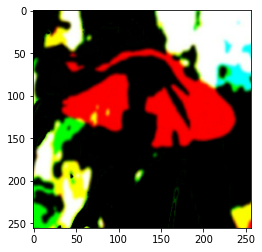

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


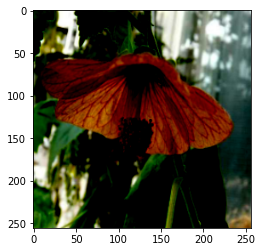

In [4]:
# Probamos que funque todo lo anterior :D
plt.imshow(load_train_image(randurls[0])[0])
plt.show()
plt.imshow(load_train_image(randurls[0])[1])

In [5]:
# Vamos a generar un dataset a partir del listado de imágenes para entrenamiento (80%)
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
# Lo anterior no carga las imágenes, es map() quien va a ejecutar load_train_image con cada imágen del tensor
# train_dataset, y además le decimos a tf que decida cuantos hilos utilizará para este proceso
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Distribuimos los datos es distintos lotes, para luego suministrarlos a la red neuronal
# para aplicar el proceso de optimización, en el paper de pix2pix utilizan lotes de 1 así que 1
train_dataset = train_dataset.batch(1)

# Ahora hacemos lo mismo con el test
test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

In [ ]:
# En este momento tenemos el dataset listo con en cada loste un par de datos inimg y tgimg
# podemos pedirle por ejemplo que devuelva X número de lotes de la siguiente forma:
train_dataset.take(5) # devuelve los objetos de 5 lotes
# podemos iterar sobre los lotes:
for inimg, tgimg in train_dataset.take(5):
  plt.imshow(tgimg[0,...])
  plt.show()

### Pasemos al fin a diseñar la arquitectura **pix2pix**

Para ello vamos a apoyarnos en los datos del apendice del paper

In [7]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

# ENCODER
def downsample(filters, apply_batchnorm = True):
  result = Sequential() # secuencia de capas

  initializer = tf.random_normal_initializer(0, 0.02) # (media, desviacion estandard)

  # capa convolucional 2D
  result.add(Conv2D(filters, 
                    kernel_size = 4, # 4x4
                    strides = 2,
                    padding = "same", # conservar el tamaño de los mapas de caracteristicas
                    kernel_initializer = initializer,
                    use_bias = not apply_batchnorm))

  if apply_batchnorm:
    # capa de BatchNormalization
    result.add(BatchNormalization())

  # capa de activacion LeakyReLu +/- = a Relu
  result.add(LeakyReLU())

  return result

In [8]:
# DECODER
def upsample(filters, apply_dropout = False):
  result = Sequential() # secuencia de capas

  initializer = tf.random_normal_initializer(0, 0.02) # (media, desviacion estandard)

  # capa convolucional 2D
  result.add(Conv2DTranspose(filters, 
                            kernel_size=4, # 4x4
                            strides=2,
                            padding="same", # conservar el tamaño de los mapas de caracteristicas
                            kernel_initializer=initializer,
                            use_bias = False))

  # capa de BatchNormalization
  result.add(BatchNormalization())

  if apply_dropout:
    # Capa de Dropout, desconecta de manera aleatoria algunas conexiones
    # de la red neuronal
    result.add(Dropout(0.5)) # 0.5 porque lo dice el paper

  # capa de activacion Relu
  result.add(ReLU())

  return result

In [9]:
# Modelo generador es una capa de tipo U-Net

def Generator():
  # Especificamos la capa de entrada
  # Dimeniones [None, None, 3] = [Ancho, Largo, Canales de Colores]
  # Ancho y Largo a None para poder meter imágenes de diff dimensiones
  inputs = tf.keras.layers.Input(shape = [None, None, 3])

  # Bloques que conforman la red, esto se saca del Apendice del paper
  # encoder: C64-C128-C256-C512... lo mismo para el up_stack (decoder)

  # Los comentarios de la derecha son las dimensiones de las imágenes resultantes
  # osea, tenemos bs que es el batch size, y si metemos una imágen de 256x256
  # pues sabemos que en el downsample disminuye a la mitad por lo que queda 128x128
  # y luego quedan 64 mapas de caracteristicas (pues tenemos 64 filtros)
  down_stack = [
    downsample(64, apply_batchnorm = False), # (bs, 128, 128, 64)
    downsample(128),                         # (bs, 64,  64,  128) 
    downsample(256),                         # (bs, 32,  32,  256) 
    downsample(512),                         # (bs, 16,  16,  512) 
    downsample(512),                         # (bs, 8,   8,   512) 
    downsample(512),                         # (bs, 4,   4,   512) 
    downsample(512),                         # (bs, 2,   2,   512) 
    downsample(512),                         # (bs, 1,   1,   512) 
  ]

  up_stack = [
    upsample(512, apply_dropout = True),     # (bs, 2,   2,   1024)
    upsample(512, apply_dropout = True),     # (bs, 4,   4,   1024)
    upsample(512, apply_dropout = True),     # (bs, 8,   8,   1024)
    upsample(512),                           # (bs, 16,  16,  1024)
    upsample(256),                           # (bs, 32,  32,  512)
    upsample(128),                           # (bs, 64,  64,  256)
    upsample(64),                            # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0, 0.02)
  # Última capa que genera la imágen final, la imágen que estamos buscando
  last = Conv2DTranspose(filters = 3,
                         kernel_size = 4,
                         strides = 2,
                         padding = "same", 
                         kernel_initializer = initializer,
                         activation = "tanh")
                         # usamos tanh por que las imágenes vienen del rango [-1, 1]
                         # que tiene el modelo de salida de [-1, 1]
  
  # Por ahora no hemos conectado nada entre capas, solo hemos escrito como es la estructura vamos,
  # pasemos a a conectar las capas
  x = inputs # primera capa

  s = [] # para las skeap connections
  concat = Concatenate() # para las skeap connections

  for down in down_stack:
    x = down(x) # conectamos cada capa del decodificador, la 1 x es inputs
    s.append(x)

  # le damos la vuelta a la lista eliminando además el último elemento 
  # que es la capa (bs, 1, 1, 512) y es justo el punto de cuello de botella
  # y así ahora conectaremos la primera capa del up_stack con la última del down_stack
  # para hacer las skeap connections
  s = reversed(s[:-1])
  
  for up, sk in zip(up_stack, s):
    # en el caso de la 1 iteración nos quitaremos el cuello de botella 1x1
    x = up(x)
    x = concat([x, sk]) # skeap connection

  last = last(x)

  return Model(inputs = inputs, outputs = last)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


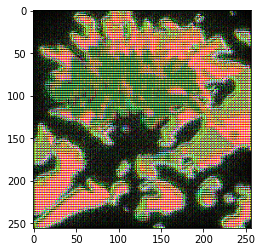

In [10]:
generator = Generator()
gen_output = generator(((inimg + 1) * 255), training = False)
plt.imshow(gen_output[0, ...])

Ahora que tenemos el generador nos queda por hacer el discriminador, que es quien decide si la imágen creada por el generador es o no una imágen cierta o falsa respecto a lo que el disciminador considere que es una imágen correcta. 

In [11]:
# Implementos la PatchGan del paper
# Sobre el paper, vamos a hacer el discriminador 70x70

def Discriminator():
  ini = Input(shape = [None, None, 3], name = "input_img")
  gen = Input(shape = [None, None, 3], name = "gener_img")

  con = concatenate([ini, gen])

  initializer = tf.random_normal_initializer(0, 0.02)

  down_1 = downsample(64, apply_batchnorm = False)(con)
  down_2 = downsample(128)(down_1)
  down_3 = downsample(256)(down_2)
  down_4 = downsample(512)(down_3)

  last = tf.keras.layers.Conv2D(filters = 1,
                                kernel_size = 4,
                                strides = 1,
                                kernel_initializer = initializer,
                                padding = "same")(down_4)

  return tf.keras.Model(inputs = [ini, gen], outputs = last)

TensorShape([1, 16, 16, 1])

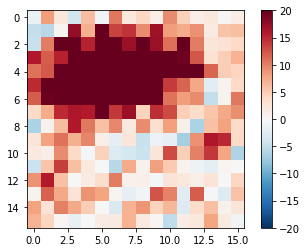

In [12]:
discriminator = Discriminator()
disc_out = discriminator([((inimg + 1) * 255), gen_output], training = False)
plt.imshow(disc_out[0, ..., -1], vmin = -20, vmax = 20, cmap = 'RdBu_r')
plt.colorbar()
disc_out.shape

In [15]:
# Por último construimos la funcion de coste adversaria que es la que va a unir 
# el generador y discriminador y tener el coste en el entrenamiento
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True) # por dentro utiliza una sigmoide

In [16]:
def discriminator_loss(disc_real_output, disc_generated_output):
  # Diferencia entre los true por ser real y el detectado por el discriminador
  # esto básicamente dice, oye, calculame la diferencia entre la imágen real que has observado
  # y una matriz que tiene todo a 1's (1's es que la imágen es real)
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  # Diferencia entre los false por ser generado y el detectado por el discriminador
  # lo mismo que arriba pero para ver el error con la imágen generada, solo que en vez de 1's
  # con 0's es decir el caso en el que el discriminador diga que los píxeles son falsos
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  return real_loss + generated_loss

In [17]:
# Ahora que hemos evaluado al discriminador, evaluemos al generador

# Para añadir mayor o menor peso al error de l1_loss
# el paper dice que 100 es bien :D así que 100
LAMBDA = 100

# El objetivo del generador es generar una imágen realista
# y también tiene que conseguir que el error del discriminador se se minimice
# básicamente va a tratar de engañar al discriminador
def generator_loss(disc_generated_output, gen_output, target):
  # Esta linea trata de evaluar si esta o no engañando al discriminador
  gran_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output) # error adversario

  # media absoluta del error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  return gan_loss + (LAMBDA * l1_loss)

Cosas para prepararnos para entrenar a la red :D

In [20]:
import os

# Adam para optimizar las funciones
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Guardado de checkpoints para que google colab no nos trolee :D
# Por que se reseta tras X tiempo de ausencia :( y va a tardar mucho 
# por lo que google colab acabará mandando a la caca la VM y pues el checkpoint
# es para no perder las horas de tiempo de entrenamiento :D
checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Para restaurar:
# checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [21]:
# Toda esta vaina para evaluar el estado de nuestro modelo generador,
# para ver las imágenes vamos

def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + 'output/' + save_filename + '.jpg', prediction[0, ...])

  plt.figure(figsize=(10,10))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # Valor de los pixeles entre [0, 1] para plot
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    
  plt.show()

In [ ]:
def train_step(input_image, target):

  with GradientTape() as gen_tape, GradientTape() as discr_tape:
    # Primero el generador toma la imágen de entrada, la pasará por el encoder
    # luego por el decoder y tendremos una img de salida
    output_image = generator(input_image, training=True)

    # Ahora optenemos lo que el discriminador piensa de la imagen creada por el gen
    # y la real que estamos buscando
    output_gen_discr = discriminator([output_image, input_image], training=True)
    output_trg_discr = discriminator([target, input_image], training=True)

    # funciones de coste para ver cual es el error
    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)
    gen_loss = generator_loss(output_gen_discr, output_image, target)

    # ahora vamos a optimizar el error, con los gradientes y estas cosas,
    # y el backpropagation...keras y tf son nuestros amigos aquí :D
  

In [22]:
from IPython.display import clear_output

# Rutina de entrenamiento, le pasamos el dataset de entrenamiento o test
# y el número de épocas que queremos que se cumpla, y pasamos la imágen que queremos 
# entrenar y la real a train_step() que es la función que entrena
def train(dataset, epochs):
  for epoch in range(epochs):
    imgi = 0
    for input_image, target in dataset:
      print('epoch' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
      imgi += 1
      train_step(input_image, target)

    clear_output(wait=True)

    # esto de aquí es simplemente para guardar imágenes en el drive y luego
    # poder hacer un gif tope de chulo con la evolución de como ha ido aprendiendo la vaina esta
    for inp, tar in test_dataset.take(5):
      generate_images(generator, inp, tar, str(imgi) + '_' + str(epoch), display_imgs=True)

    # Guardamos cada 20 epochs para el backup
    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)